In [7]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix

path = '../../results'
output_path = '../../figures'
f_with_aneuploidy = 'basic-prior'

In [8]:
def sample_from_kde(file_name, size=5_000_000, t=None):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, file_name))
    samples, weights = history.get_distribution(m=0, t=t)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    order_criteria = (kdesamples['2n+1 fitness'] < kdesamples['2n+1* fitness']) & (kdesamples['2n+1* fitness'] < kdesamples['2n* fitness'])
    kdesamples = kdesamples[(kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) &
              (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2) & order_criteria][:size]
    return kdesamples, kde

samples,kde = sample_from_kde(f_with_aneuploidy)
map_params = scipy.optimize.minimize(lambda x: -kde.logpdf(x) if x[0]>1e-9 and x[0]<1e-5 
                          and x[1]>1e-6 and x[1]<1e-2 else 100000
                          ,samples.median().values)['x']
map_params

array([3.00715306e-06, 1.74028636e-03, 1.02215176e+00, 1.02472365e+00,
       1.02787564e+00])

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# sns.set(font_scale=1.5, rc={"lines.linewidth": 2.5, 'lines.markersize': 8})
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 1.5, 'lines.markersize': 4})

from operator import itemgetter
def replace(arr,i,e):
    arr = list(arr) #for tuples
    ans = arr[:i]+[e]+arr[i+1:]
    return ans

def calculateGrades(default, i, rangee, reps, defaultGrade, points,seed=20):
    if type(i) is not list:
        i = [i]
    grades = [] 
    for r in rangee:
        params = list(default)
        for j in i:
            params = replace(params,j,r)
        times_p = model.run_simulations(*params, repetitions=reps,seed=seed)
        grade = model.grade_function(times_p)
        grades.append((r,-grade))
    
    defGrade = (default[i[0]], defaultGrade)
    grades.append((default[i[0]], defaultGrade))
    
    grades.sort(key=itemgetter(0))
    
    return (grades, defGrade)

def plotGrades(xlabel, gg, letter, x_log_scale=True, showylabel=False):
#     grades,defaultGrade,pointGrades = gg # now we don't have pointGrades
    grades, defaultGrade = gg
    plt.plot(list(zip(*grades))[0], [g+1e-10 for g in list(zip(*grades))[1]], '-o', color='black')
    
#     plt.plot(defaultGrade[0], defaultGrade[1], 'ro', label=str(round(defaultGrade[0],3))+' - best fit')
    
    plt.axvline(defaultGrade[0],linestyle='--',linewidth=1, color="black")

    plt.xlabel(xlabel)
    if showylabel:
        plt.ylabel(r'Approximate likelihood, $L(\theta)+10^{-10}$',fontsize=15)

    plt.yscale('log')
    if x_log_scale:
         plt.xscale('log')
        
    ax = plt.gca()
    ax.text(-0.1, 1.05, letter, transform=ax.transAxes, size=20, weight='bold')
    plt.gcf().savefig(f'{output_path}/sensitivity-{letter}.pdf', bbox_inches='tight')
    plt.show()

### You can jump to [loading section](#loading) if you want only to plot figure and the data is already persisted

In [10]:
%%time

def construct_space(bounds, center):
    # (l1,l2) bounds
    # (s,e) most points
    l1, l2 = bounds
    s, e = center
    sbefore = np.logspace(np.log10(l1), np.log10(s),5)
    smiddle = np.logspace(np.log10(s),np.log10(e),24)
    safter = np.logspace(np.log10(e), np.log10(l2),5)
    return np.concatenate((sbefore[:-1], smiddle[1:], safter[1:]))

import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1)
N = 6*10**6
reps = 10000

params = [map_params[0],map_params[1],map_params[1],*map_params[2:]] #aneuplloidy gane and loss are the same

times_p = model.run_simulations(*[N,*params] , repetitions=reps,seed=123)
g = model.grade_function(times_p)


CPU times: user 6min 50s, sys: 3.44 s, total: 6min 53s
Wall time: 8min 44s


In [11]:
%%time
space = construct_space((1e-9, 1e-5), (6e-7, 1e-5)) 
mu_grades = calculateGrades([N,*params], 1, space, reps, -g, [], seed=123)

CPU times: user 3h 46min 20s, sys: 1min 12s, total: 3h 47min 33s
Wall time: 3h 49min 32s


In [12]:
%%time
space = construct_space((1e-6, 1e-2), (2e-4, 1e-2))
lambda_grades = calculateGrades([N,*params], [2,3], space, reps, -g, [], seed=123) #gain and loss replace together

CPU times: user 4h 46min 40s, sys: 5min 25s, total: 4h 52min 6s
Wall time: 20h 44min 43s


In [13]:
%%time
space = construct_space((1.02, 1.025), (1.0215, 1.023))
w_anwt = calculateGrades([N,*params], 4, space, reps, -g, [], seed=123);

CPU times: user 3h 28min 44s, sys: 1min 5s, total: 3h 29min 49s
Wall time: 3h 33min 34s


In [14]:
%%time
space = construct_space((1.01, 1.04), (1.021, 1.032))
w_anmt = calculateGrades([N,*params], 5, space, reps, -g, [], seed=123);

CPU times: user 3h 42min 36s, sys: 46.1 s, total: 3h 43min 22s
Wall time: 3h 44min 56s


In [15]:
%%time
# space = np.logspace(np.log10(1.026),np.log10(1.029),18)
space = construct_space((1.025, 1.031), (1.027, 1.0285))
w_eumt = calculateGrades([N,*params], 6, space, reps, -g, [], seed=123);


CPU times: user 3h 9min 3s, sys: 38.2 s, total: 3h 9min 41s
Wall time: 3h 10min 59s


In [16]:
np.savez('./outputs/sensitivity2',mu_grades=mu_grades, 
                     lambda_grades=lambda_grades, w_anwt=w_anwt, w_anmt=w_anmt, w_eumt=w_eumt)

<a id='loading'></a>
## Loading section

In [17]:
# load = np.load('./outputs/sensitivity.npz',allow_pickle=True)
# mu_grades, lambda_grades, w_anwt, w_anmt, w_eumt = load['mu_grades'], load['lambda_grades'], load['w_anwt'], load['w_anmt'], load['w_eumt']

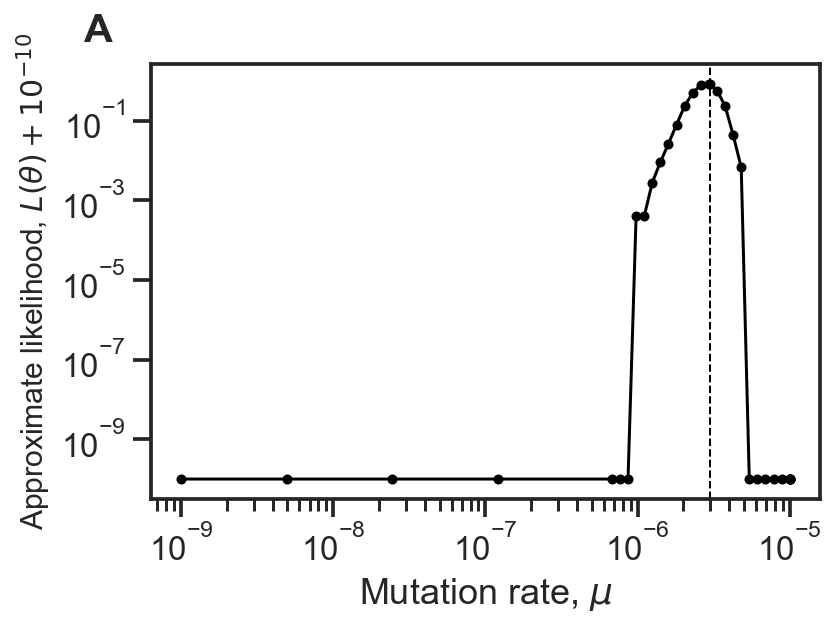

In [18]:
plotGrades('Mutation rate, $\mu$', mu_grades, letter='A', x_log_scale=True, showylabel=True)

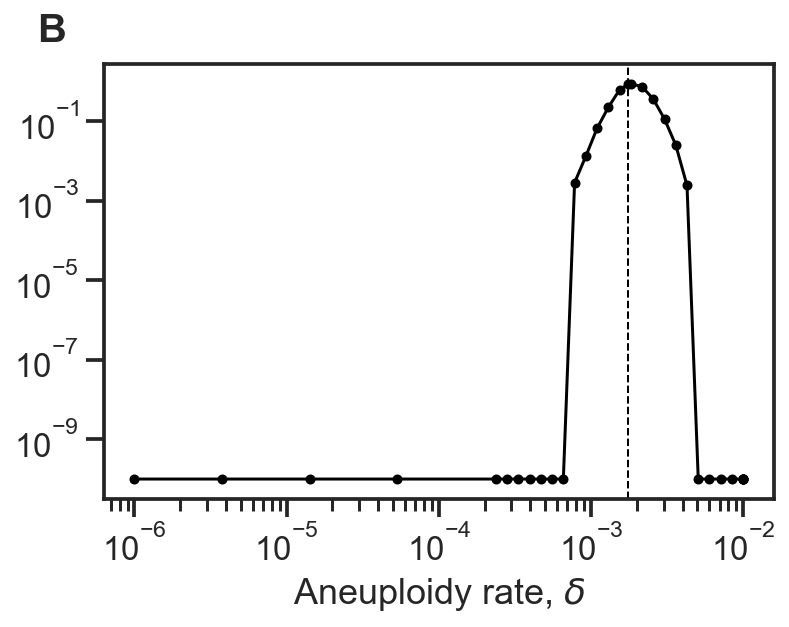

In [19]:
plotGrades('Aneuploidy rate, $\delta$', lambda_grades, letter='B', x_log_scale=True, showylabel=False)

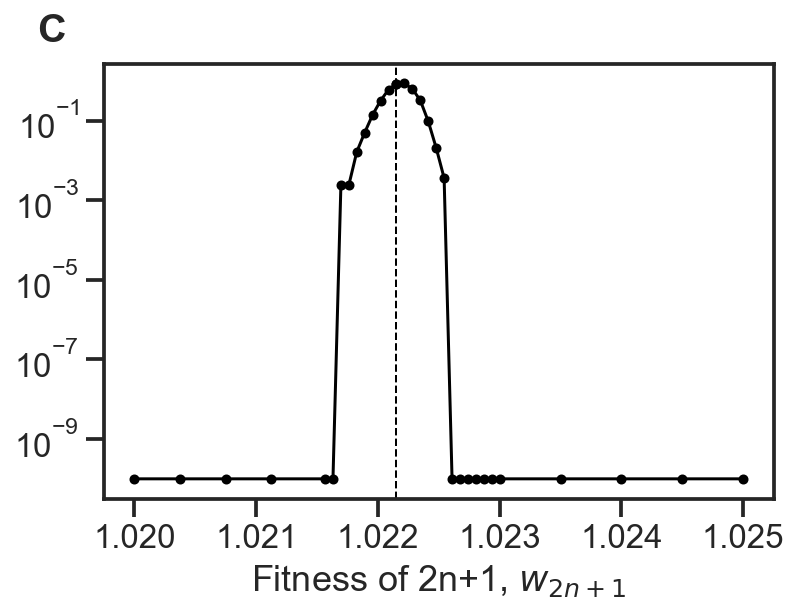

In [20]:
plotGrades('Fitness of 2n+1, $w_{2n+1}$', w_anwt, letter='C', x_log_scale=False, showylabel=False)

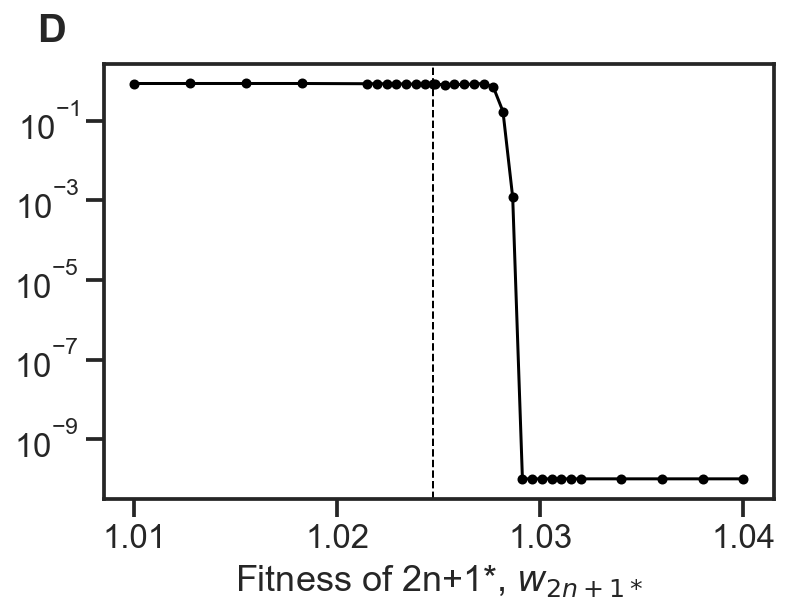

In [21]:
plotGrades('Fitness of 2n+1*, $w_{2n+1*}$', w_anmt, letter='D', x_log_scale=False, showylabel=False)

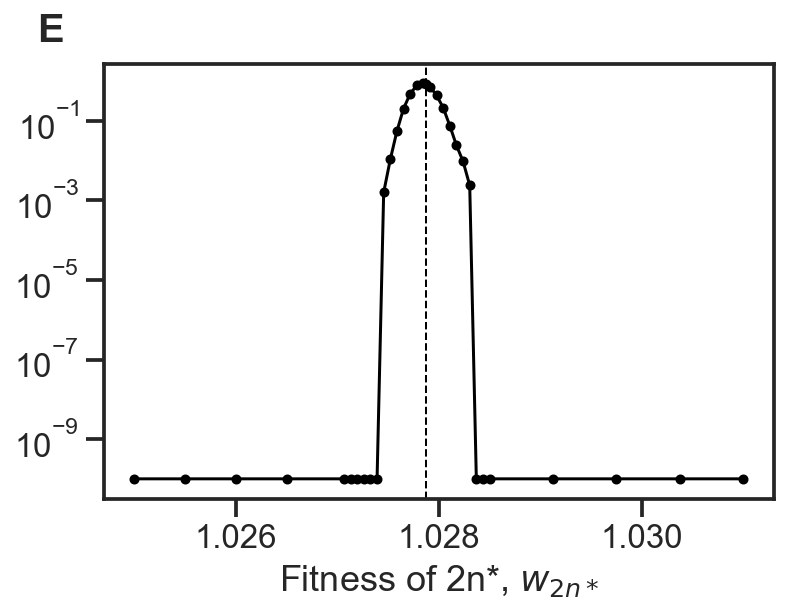

In [22]:
plotGrades('Fitness of 2n*, $w_{2n*}$', w_eumt, letter='E', x_log_scale=False, showylabel=False)